# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf #### Add your code here ####
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load("/content/drive/My Drive/Colab Notebooks/GL-AIML-Modules-PythonExcercise/10 Computer Vision/Week 5 - Advanced Computer Vision Project (Object Detection) - Learning Material - Project/images.npy", allow_pickle= True)

### Check one sample from the loaded "images.npy" file  (4 marks)

In [4]:
data.shape

(409, 2)

In [5]:
type(data)

numpy.ndarray

In [49]:
data[100][0].shape

(720, 1280, 3)

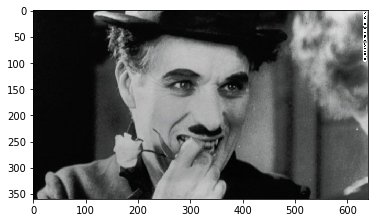

In [58]:
#### Add your code here ####
from matplotlib import pyplot as plt

plt.imshow(data[102][0])
plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [61]:
X_train.shape #### Add your code here ####

(409, 224, 224, 3)

In [62]:
masks.shape #### Add your code here ####

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  ...
  [ 0.58431375  0.7019608   0.74117649]
  [ 0.34901965  0.4666667   0.50588238]
  [ 0.25490201  0.37254906  0.41176474]]

 [[ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  ...
  [ 0.58431375  0.7019608   0.74117649]
  [ 0.34901965  0.4666667   0.50588238]
  [ 0.25490201  0.37254906  0.41176474]]

 [[ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  [ 0.96862745  1.          0.99215686]
  ...
  [ 0.59215689  0.70980394  0.74901962]
  [ 0.34901965  0.4666667   0.50588238]
  [ 0.25490201  0.37254906  0.41176474]]

 ...

 [[ 0.29411769  0.3176471   0.36470592]
  [ 0.26274514  0.27843142  0.35686278]
  [ 0.53725493  0.56078434  0.65490198]
  ...
  [-0.43529409 -0.40392154 -0.38039213]
  [-0.45098037 -0.41960782 -0.39607841]
  [-0.47450978 -0.44313723 -0.41960782]]

 [

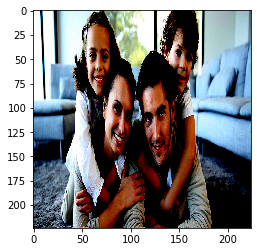

In [63]:
from matplotlib import  pyplot

n = 13
print(X_train[n])
pyplot.imshow(X_train[n])

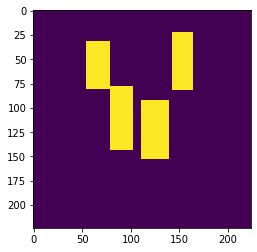

In [64]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
EPOCHS = 50
BATCH_SIZE = 1
PATIENCE = 10
ALPHA = 1.0

HEIGHT_CELLS = 224
WIDTH_CELLS = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

THREADS = 1

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    # model.summary()
    block_2 = model.get_layer("conv_pw_1_relu").output
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [67]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step
(?, 14, 14, 1536)
(?, 28, 28, 1792)
(?, 56, 56, 1920)
(?, 112, 112, 1984)
(?, 224, 224, 1984)
(?, 224, 224)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
______________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon()) #### Add your code here ####

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
# train_datagen = X_train  #### Add your code here ####
# validation_datagen = masks

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient,'accuracy'])

### Define checkpoint and earlystopping

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [91]:
model.fit(X_train, masks, epochs= EPOCHS, batch_size= BATCH_SIZE, verbose=True, workers=THREADS,callbacks=[checkpoint, reduce_lr, stop],use_multiprocessing=True,validation_split=0.1)

Train on 368 samples, validate on 41 samples
Epoch 1/50
366/368 [============================>.] - ETA: 0s - loss: 0.2977 - dice_coefficient: 0.8344 - acc: 0.0214
Epoch 00001: loss did not improve from 0.29552
368/368 [==============================] - 15s 42ms/sample - loss: 0.2976 - dice_coefficient: 0.8341 - acc: 0.0213 - val_loss: 0.5357 - val_dice_coefficient: 0.7095 - val_acc: 0.0134
Epoch 2/50
367/368 [============================>.] - ETA: 0s - loss: 0.2967 - dice_coefficient: 0.8346 - acc: 0.0214
Epoch 00002: loss did not improve from 0.29552
368/368 [==============================] - 15s 40ms/sample - loss: 0.2965 - dice_coefficient: 0.8348 - acc: 0.0213 - val_loss: 0.5310 - val_dice_coefficient: 0.7123 - val_acc: 0.0158
Epoch 3/50
367/368 [============================>.] - ETA: 0s - loss: 0.2962 - dice_coefficient: 0.8351 - acc: 0.0217
Epoch 00003: loss did not improve from 0.29552
368/368 [==============================] - 15s 40ms/sample - loss: 0.2959 - dice_coefficient: 

### Get the predicted mask for a sample image   (5 marks)

In [0]:
model.load_weights("model-0.27.h5")

In [93]:
print(model.input_shape,)
print(model.output_shape)
print(X_train.shape)

(None, 224, 224, 3)
(None, 224, 224)
(409, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


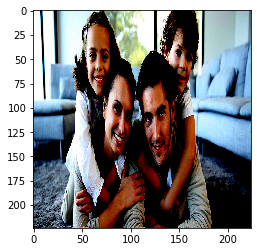

In [94]:
n = 13
sample_image = X_train[n]
print(sample_image.shape)
pyplot.imshow(sample_image)

#### Add your code here ####

(1, 224, 224, 3)
(1, 224, 224)


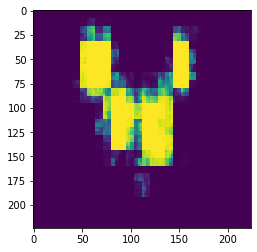

In [95]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
print(sample_image.shape)
pred_face = model.predict(sample_image,)
print(pred_face.shape)
pred_face = np.resize(pred_face, (224, 224))
pyplot.imshow(pred_face)

### Impose the mask on the image (5 marks)

In [0]:
imp_pred_face = np.resize(pred_face, (224,224))
res_image = np.resize(sample_image,  (224,224,3))
pyplot.imshow(res_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


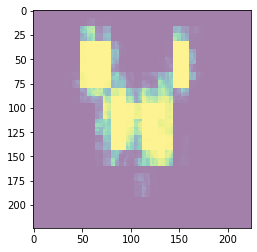

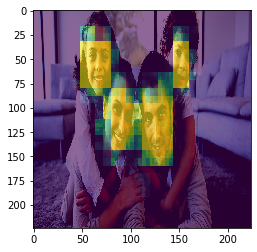

In [96]:
#### Add your code here ####
pyplot.imshow(imp_pred_face, alpha=0.5)

fig = plt.figure(frameon=False)
im1 = plt.imshow(res_image)
im2 = plt.imshow(imp_pred_face,alpha=.6)
plt.show()